# Work space for Nick

In [1]:
from PIL import Image
from os import listdir
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import daisy
from sklearn.metrics.pairwise import pairwise_distances
import copy
from ipywidgets import fixed
from ipywidgets import widgets  # make this interactive!
from skimage.io import imshow


def gray_sacle(data):
    return np.dot(data[...,:3], [0.299, 0.587, 0.114])

def read_images(directories, verb = False):
    """Reads in the all and rem directoires under each directory in the list directories"""
    X = []
    y = []
    for direct in dirs:
        if verb:
            print(f"Reading {direct}")
        direct_all = f"{direct}\\all"
        for file in listdir(direct_all):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_all}\\{file}")
            data = np.asarray(image)
            data = gray_sacle(data)
            data = data.ravel()
            X.append(data)
            y.append(1)
                
        direct_hem = f"{direct}\\hem"
        for file in listdir(direct_hem):
            if verb:
                print(f"Reading file: {file}")
            image = Image.open(f"{direct_hem}\\{file}")
            data = np.asarray(image)
            data = gray_sacle(data)
            data = data.ravel()
            X.append(data)
            y.append(0)
                
    return np.asarray(X), np.asarray(y)

def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [2]:
%%time
dirs = [
    r'..\archive\C-NMC_Leukemia\training_data\fold_0',
    #r'..\archive\C-NMC_Leukemia\training_data\fold_1',
    #r'..\archive\C-NMC_Leukemia\training_data\fold_2'
    #r'..\archive\C-NMC_Leukemia\training_data\fold_small'
]
X, y = read_images(dirs, verb=False)
print(X.shape)

(3521, 202500)
Wall time: 51.2 s


Wall time: 2.01 s


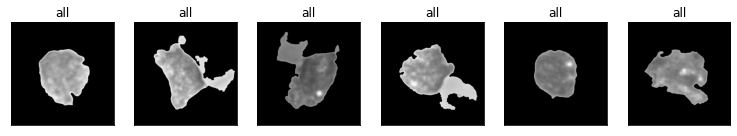

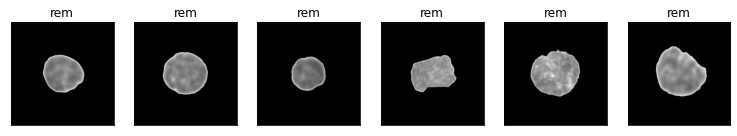

In [3]:
%%time
plot_gallery(X[np.where(y==1)], ['all' for i in range(6)], h=450, w=450, n_row=1, n_col=6)
plot_gallery(X[np.where(y==0)], ['rem' for i in range(6)], h=450, w=450, n_row=1, n_col=6)


# Data Reduction
* Perform linear dimensionality reduction of the images using **principal components analysis**. Visulize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain analysis and conclusion.
* Compare the representation using PCA and Randomized PCA. The method you choose to comapre dimensionality methods should quantitatively explain which method is better at reresenting the images with fewer components. Do you prefer one method over another? Why?
* Perform **feature extraction** upon the images using any feature extraction technique (gabor filerts, ordered gradients, DAISY)
* Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences **between statistics of extracted features** in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

## Perform Feature Extraction upont the images using DAISY

In [36]:
# (your code)
def apply_daisy(row,shape,
                step=80,
                radius=60,
                rings=3,
                histograms=4,
                orientations=8,
                visualize=False):
    feat = None
    img_desc = None
    if not visualize:
        feat = daisy(row.reshape(shape),step=step, radius=radius, rings=rings,
                     histograms=histograms, orientations=orientations, visualize=False)
        return feat.reshape((-1))
    else:
        feat, img_desc = daisy(row.reshape(shape),step=step, radius=radius, rings=rings,
                     histograms=histograms, orientations=orientations, visualize=True)
        
        return feat.reshape((-1)), img_desc
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 5, 104)
2600


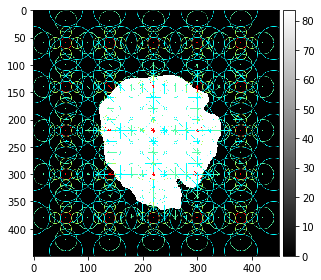

In [37]:
h = 450
w = 450
img = X[0].reshape((h,w))
test_feature, img_desc = daisy(img,
                                 step=80,
                                 radius=60,
                                 rings=3,
                                 histograms=4,
                                 orientations=8,
                                 visualize=True)

imshow(img_desc, cmap=plt.cm.gray)
plt.grid(False)
print(test_feature.shape)
print(test_feature.shape[0]*test_feature.shape[1]*test_feature.shape[2])

In [38]:
%%time
# estimate wait time
test_feature = apply_daisy(X[0],
                          (h,w),
                          visualize=False)
print(len(X)*500/1000/60)

29.341666666666665
Wall time: 863 ms


In [39]:
%%time
daisy_features = np.apply_along_axis(apply_daisy,
                                     1,
                                     X,
                                     (450,450))

Wall time: 49min 56s


In [40]:
%time dist_matrix = pairwise_distances(daisy_features)

Wall time: 377 ms


In [41]:
def closest_image(dmat_daisy, idx1):
    # NOTE: this will not suffice for evaluation of a nearest neighbor classifier for your lab assignment
    distances = copy.deepcopy(dmat_daisy[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,2,1)
    imshow(X[idx1].reshape((h,w)), cmap=plt.cm.gray)
    plt.title(f"Original Image {idx1} {y[idx1]}")
    plt.grid()

    plt.subplot(1,2,2)
    imshow(X[idx2].reshape((h,w)), cmap=plt.cm.gray)
    plt.title(f"DAISY Closest  {idx2} {y[idx2]}")
    plt.grid()
    
n_samples, n_features, = X.shape
widgets.interact(closest_image,idx1=(0,n_samples-1,1),
                 dmat_daisy=fixed(dist_matrix),
                 __manual=True)

interactive(children=(IntSlider(value=1760, description='idx1', max=3520), Output()), _dom_classes=('widget-in…

<function __main__.closest_image(dmat_daisy, idx1)>

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def run_knn(X, y, neighbors=1):
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, train_size=0.8)

    x_knn = KNeighborsClassifier(n_neighbors=neighbors)


    x_knn.fit(x_train,y_train)
    acc = accuracy_score(x_knn.predict(x_test),y_test)

    # accuracy for positive cases (all)
    x_test_all = x_test[np.where(y_test==1)[0]]
    acc_all = accuracy_score(x_knn.predict(x_test_all), [1 for i in range(len(x_test_all))])

    # accuracy for Negative cases (rem)
    x_test_hem = x_test[np.where(y_test==0)[0]]
    acc_hem = accuracy_score(x_knn.predict(x_test_hem), [0 for i in range(len(x_test_hem))])


    return 100*acc, 100*acc_all, 100*acc_hem

In [45]:
%%time
run_knn(daisy_features, y, neighbors=20)

Wall time: 15.7 s


(82.97872340425532, 89.21161825726142, 69.50672645739911)

In [11]:
daisy_features.shape

(3521, 133128)

In [12]:
X.shape

(3521, 202500)